<div style="text-align: right"> Mark Hendricks </div>

<left>FINM 36700 - Portfolio Theory and Risk Management</left> 
<br>
<left>Fall 2022</left>

<h2><center> Homework 4 - Dimensional Fund Advisors, 2002 </center></h2>

<center>Due on Monday, Oct 24</center>

<h3><span style="color:#00008B">Solution - Piyush Kontu</span></h3>

<h3><span style="color:#00008B">Email - pkontu@uchicago.edu</span></h3>

### Dimensional Fund Advisors, 2002 [HBS 9-203-026].

### Pages 1-5 of the case are required. Pages 6-11 get into interesting issues around trading (especially adverse selection) and tax considerations. These sections are useful for building market knowledge, but we will not cover them.


## 1. DFA's Strategy

#### <i> This section is not graded, and you do not need to submit your answers. But you are expected to consider these issues and be ready to discuss them.</i>

### 1.1 Investment Philosophy

#### 1.1.a) In 100 words or less, describe DFA's belief about how to find premium in the market.

- DFA believed market was "efficient".
- The firm primarily based its strategy on the Fama-French 3 factor model which postulates that high market-beta, High Book-to-market and small stocks had risk premiums.
- In addition they believe they can generate excess returns through tax-efficient, and transaction-cost efficient investing. 


#### 1.1.b) To what degree does their strategy rely on individual equity analysis? Macroeconomic fundamentals? Efficient markets?

- DFA's strategies are largely reliant on market efficiency and Linear factor models and they do not take directional single stock or macroeconomic bets.
- Their LFM strategies are based on the long term permium generated through the exposure to Value, Size and Market factors.
- DFA relies on optimized execution, market-making, and tax considerations. 

#### 1.1.c) Are DFA's funds active or passive?

- DFA's funds are majorly passive and are based on index portfolios exposed to the Fama French factors.

#### 1.1.d) What do DFA and others mean by a "value" stock? And a "growth" stock?

- **Value** - Stocks with high book to market ration (BE/ME). These stocks show a lot of accounting value, (via book equity,) relative to the market price, (market equity).
- **Growth** - Stocks with low book to market ration (BE/ME) <br><br>
- Other accounting measures that can be used for this classification are earnings-price ratios or dividend-price ratios. Earnings can be negative and thus are generally avoided.

### 2.2 Challenges for DFA's view.
#### 2.2.a) What challenge did DFA's model see in the 1980's?

- US was into a deep recession in 1980 and small companies werer particularly hard hit. Even with the subsequent boom in the economy small companies continued to lag.
- DFA needed to assess whether this underperformance was temporary or the size factor had a systematic flaw.

#### 2.2.b) And in the 1990's?

-  In the 1990's, DFA saw value stocks greatly under-perform growth stocks, partially driven by the incredible returns of tech stocks. 
- This finally started turning around in 2000 and 2001 when value stocks greatly outperformed growth stocks, especially with the crash of the so-called tech bubble.

### 2.3 The market.

#### 2.3.a) Exhibit 3 has data regarding a universe of 5,020 firms. How many are considered "large cap"? What percent of the market value do they account for?

- In the exhibit there are 207 large cap firms ( < 5% of total count), yet they constitute about 70% of the market cap in the universe.

#### 2.3.b) Exhibit 6 shows that the U.S. value factor (HML) has underperformed the broader U.S. equity market in 1926-2001, including every subsample except 1963-1981. So why should an investor be interested in this value factor?

- Even if Value has underperformed the market in these subsamples, it's imperfect correlation with the market could lead to diversification benefits as we saw in the MV optimization. 
- This imperfect correlation can lead to risk reduction at the margin for any investor completely invested in funds tracking the broader equity index.


# Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import kurtosis, skew
from scipy.stats import norm
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(rc={'figure.figsize':(15, 6)})

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Helper Functions

In [2]:
def performance_summary(return_data):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*12)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(12))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [3]:
def regression_based_performance(factor,fund_ret,rf,constant = True):
    """ 
        Returns the Regression based performance Stats for given set of returns and factors
        Inputs:
            factor - Dataframe containing monthly returns of the regressors
            fund_ret - Dataframe containing monthly excess returns of the regressand fund
            rf - Monthly risk free rate of return
        Output:
            summary_stats - (Beta of regression, treynor ratio, information ratio, alpha). 
    """
    if constant:
        X = sm.tools.add_constant(factor)
    else:
        X = factor
    y=fund_ret
    model = sm.OLS(y,X,missing='drop').fit()
    
    if constant:
        beta = model.params[1:]
        alpha = round(float(model.params['const']),6) *12

        
    else:
        beta = model.params
    treynor_ratio = ((fund_ret - rf).mean()*12)/beta[0]
    tracking_error = (model.resid.std()*np.sqrt(12))
    if constant:        
        information_ratio = model.params[0]*12/tracking_error
    r_squared = model.rsquared
    if constant:
        return (beta,treynor_ratio,information_ratio,alpha,r_squared,tracking_error,model.resid)
    else:
        return (beta,treynor_ratio,r_squared,tracking_error,model.resid)

In [4]:
def tangency_portfolio_rfr(asset_return,cov_matrix):
    """ 
        Returns the tangency portfolio weights in a (1 x n) vector when a riskless assset is available
        Inputs: 
            asset_return - Excess return over the risk free rate for each asset (n x 1) Vector
            cov_matrix = nxn covariance matrix for the assets
    """
    asset_cov = np.array(cov_matrix)
    inverted_cov= np.linalg.inv(asset_cov)
    one_vector = np.ones(len(cov_matrix.index))
    
    den = (one_vector @ inverted_cov) @ (asset_return)
    num =  inverted_cov @ asset_return
    return (1/den) * num

# Reading Data

In [5]:
factors = pd.read_excel(r'C:\Users\piyus\Documents\Repos\finm-portfolio-2022\data\dfa_analysis_data.xlsx',sheet_name = 'factors')
factors = factors.set_index('Date')
factors = factors.drop(['RF'], axis=1)
factors.head()

,Mkt-RF,SMB,HML
Date,,,
1926-07-31,0.0296,-0.0256,-0.0243
1926-08-31,0.0264,-0.0117,0.0382
1926-09-30,0.0036,-0.0140,0.0013
1926-10-31,-0.0324,-0.0009,0.0070
1926-11-30,0.0253,-0.0010,-0.0051


In [6]:
port_ret = pd.read_excel(r'C:\Users\piyus\Documents\Repos\finm-portfolio-2022\data\dfa_analysis_data.xlsx',sheet_name = 'portfolios (total returns)')
port_ret = port_ret.set_index('Date')

rf = pd.read_excel(r'C:\Users\piyus\Documents\Repos\finm-portfolio-2022\data\dfa_analysis_data.xlsx',sheet_name = 'factors')
rf = rf.set_index('Date')
rf = rf['RF'].to_frame()
port_ret = port_ret.merge(rf['RF'], on = rf.index).fillna(0).rename(columns={'key_0' : 'Date'})
port_ret.index = port_ret['Date']
port_ret = port_ret.drop(['Date'], axis=1)
for col in port_ret.columns:
    port_ret[col] = port_ret[col] - port_ret['RF']


port_ret = port_ret.drop(['RF'], axis=1)
port_ret.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.056048,-0.019206,0.002675,-0.016780,0.018334,0.009877,0.021992,0.002726,-0.028249,-0.005544,...,0.013693,0.013078,0.010778,0.000527,0.022478,0.032339,0.058702,0.018066,0.028911,0.003423
1926-08-31,-0.022706,-0.082782,0.011296,0.012106,0.081468,0.021118,-0.014349,0.037584,0.002538,0.059175,...,0.010836,0.036230,0.017521,0.019206,0.050922,0.007624,0.039403,0.017631,0.052349,0.075076
1926-09-30,-0.050591,-0.028454,-0.045717,-0.035029,0.006349,-0.028840,-0.014918,0.008529,-0.037780,-0.011701,...,0.008623,-0.007550,-0.019936,0.012346,0.006430,-0.015206,0.034238,-0.001350,-0.009787,-0.026584
1926-10-31,-0.096929,-0.038719,-0.038148,0.031213,-0.028676,-0.031269,-0.035863,-0.053945,-0.083391,-0.016413,...,-0.036561,-0.029759,-0.024270,-0.034251,-0.056725,-0.030613,-0.033271,-0.025637,-0.049919,-0.061329
1926-11-30,0.052788,0.038777,0.021523,-0.047594,0.002262,0.027933,-0.026790,0.026978,0.048446,0.024192,...,0.031348,0.020787,0.034235,0.046220,0.015113,0.039846,0.022226,0.012104,0.033519,0.022536


## 2. The Factors

#### DFA believes certain stocks have higher expected excess returns. In addition to the overall market equity premium, DFA believes that there is a premium attached to a "size" and "value" factor. Note that these three factors are already listed as excess returns. 
#### Use the data found in <file>'dfa analysis data.xlsx'</file>.

- #### FACTORS: Monthly excess return data for the overall equity market, $\tilde{r}^{m}$. The sheet also contains data on two additional factors, SMB and HML, as well as the risk-free rate. You do not need any of these columns for the homework. Just use the MKT column, which is excess market returns. (So no need to subtract the risk-free rate.)

### 2.1 Calculate their univariate performance statistics:
- ### mean
- ### volatility
- ### Sharpe
- ### VaR(.05)

In [7]:
factor_summary = performance_summary(factors)
factor_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]

,Mean,Volatility,Sharpe Ratio,VaR (0.05)
Mkt-RF,0.080753,0.185161,0.436121,-0.079590
SMB,0.023288,0.109910,0.211879,-0.042035
HML,0.042318,0.123363,0.343037,-0.041935


### Report these for the following three subsamples:
- ### Beginning - 1980
- ### 1981 - 2001
- ### 2002 - End

In [8]:
sub_1980 = factors.loc[:'1980']
sub_2001 = factors.loc['1981':'2001']
sub_2022 = factors.loc['2002':]

df_dict={'1926-1980' : sub_1980,
         '1981-2001' : sub_2001,
         '2002-2022' : sub_2022}

summary_lst = []
for key in df_dict.keys():
    summary_stats = performance_summary(df_dict[key]).loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]
    summary_stats['Period'] = key
    summary_stats= summary_stats.reset_index().rename(columns = {'index':'Factor'}).set_index(['Period','Factor'])
    summary_lst.append(summary_stats)

factor_summary = pd.concat(summary_lst)
factor_summary#.T


Mean  Volatility  Sharpe Ratio  VaR (0.05)
Period    Factor                                                
1926-1980 Mkt-RF  0.081138    0.205050      0.395696   -0.083985
          SMB     0.033985    0.114568      0.296638   -0.043400
          HML     0.049479    0.133825      0.369727   -0.042910
1981-2001 Mkt-RF  0.077257    0.157396      0.490847   -0.064545
          SMB    -0.000876    0.118434     -0.007398   -0.046560
          HML     0.063729    0.111276      0.572706   -0.041790
2002-2022 Mkt-RF  0.083289    0.153972      0.540933   -0.078795
          SMB     0.019631    0.085788      0.228826   -0.037785
          HML     0.001679    0.104507      0.016066   -0.041000

### 2.2) Based on the factor statistics above, answer the following.

### 2.2.a) Does each factor have a premium (positive expected excess return) in each subsample?

All 3 factors possess positive premiums in the sub period leading to 1980. Between 1981-2001 the Size factor provides no mean excess returns (discount of 8 basis points), but recovers to provide some premium again between 2002 and 2022. Similarly, the Value factor, provides premium up untill 2001, post which the mean excess returns reduce significantly for the period between 2001 and 2022, with negative returns till 2021. The Market factor consistently provides positive premium throughout the period of analysis.

### 2.2.b) Does the premium to the size factor get smaller after 1980?

The premium of the size factor does decline after 1980, going almost to 0 between 1981 and 2001 and then recovering to ~1.9% (still lower than pre 1980 returns). According to a recent study by AQR Capital Management (https://www.aqr.com/Insights/Perspectives/There-is-No-Size-Effect-Daily-Edition), the size premia only exists in conjunction with the market beta factor. The apparent outperformance of small versus large caps after adjusting for market beta in the original work by Fama French on the data pre-1980's was biased by misestimated betas due to liquidity differences. 

### 2.2.c) Does the premium to the value factor get smaller during the 1990's?

The premium to value factor increases in the sub-sample of 1981-2001 as compared to 1926-1980, but then experiences a significant decline post the 2002 internet bubble burst and posits negative mean excess returns till 2021, and then recovering significantly again in 2022. 

The tech bubble in the late 1990s and early 2000s had a huge influence on the spread, as the value factor experienced significant drawdowns, with tech stocks trading at levels far from fundamentals. In general, the value factor traded at a negative spread — a logical result, since the long portfolio is always cheaper than the short. 

Source - https://blogs.cfainstitute.org/investor/2017/09/12/there-is-value-in-the-value-factor/

### 2.2.d) How have the factors performed since the time of the case, (2002-present)?

Since 2002, the Market Factor has posted highest premiums between the three subsamples. While the Size factor also posted a premium of ~2.4%, as discussed in the AQR study above, it could be interpreted as a high correlation with the market beta. The value factor is in a deep drawdown since the recovery post the Tech bubble burst. Technology disruption in 2010s and longer bull runs and recoveries aftor financial crises of 2008 and 2020, have led to companies trading farther away from their fundamentals, turning the value factor into a losing bet.

### 2.3) The factors are constructed in such a way as to reduce correlation between them. 

### Report the correlation matrix across the three factors. Does the construction method succeed in keeping correlations small? 

Overall, the correlations between the three factors are low and thus the construction method succeeds in its objective. The Size and Value factors, especially post very low correlations, but are still relatively more correlated to the market factor,

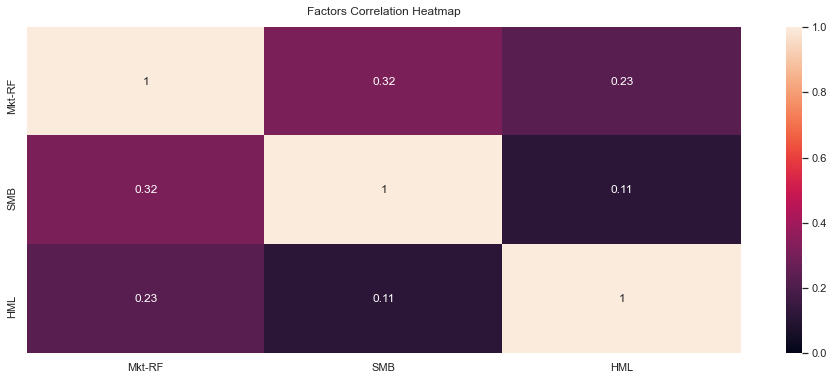

In [9]:
factor_corr = factors.corr()

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(factor_corr, vmin=0, vmax=1, annot=True)
heatmap.set_title('Factors Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Does it achieve this in each subsample?

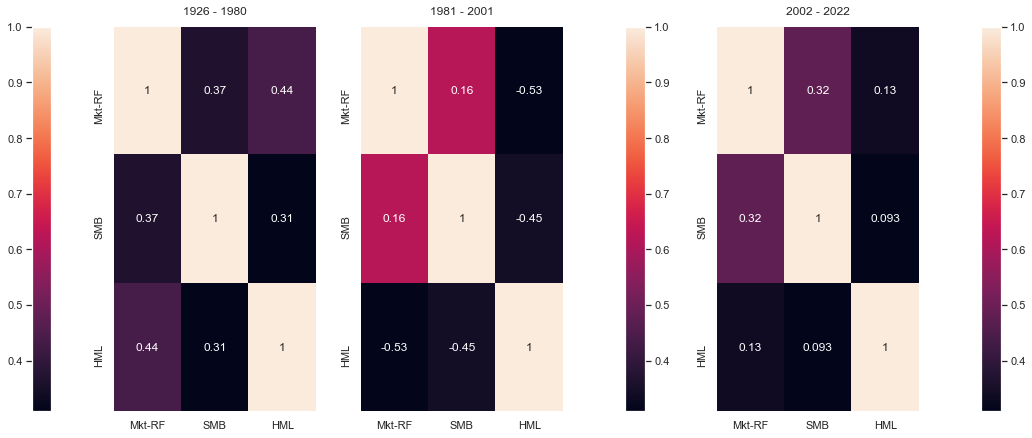

In [10]:
fig, (ax,ax2,ax3) = plt.subplots(ncols=3)

fig.subplots_adjust(wspace=0.01)
fig.tight_layout(pad=1)
sns.heatmap(sub_1980.corr(), ax=ax, cbar=False, annot = True).set_title('1926 - 1980', fontdict={'fontsize':12}, pad=12);

fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(sub_2001.corr(), ax=ax2, cbar=False, annot = True).set_title('1981 - 2001', fontdict={'fontsize':12}, pad=12);

fig.colorbar(ax.collections[0],ax=ax2,location="right", use_gridspec=False, pad=0.2)

sns.heatmap(sub_2022.corr(), ax=ax3, cbar=False, annot = True).set_title('2002 - 2022', fontdict={'fontsize':12}, pad=12);
fig.colorbar(ax.collections[0],ax=ax3,location="right", use_gridspec=False, pad=0.2)

fig.set_figwidth(15)
plt.show()

### 2.4) Plot the cumulative returns of the three factors. Create plots for the 1981-2001 subsample as well as the 2002-Present subsample.

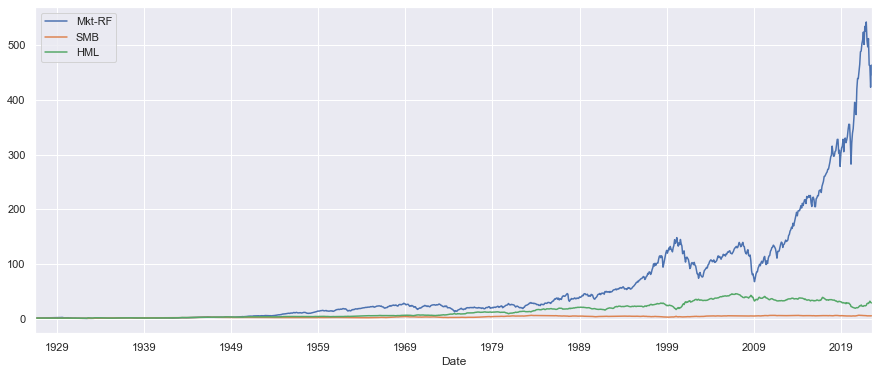

<Figure size 7200x432 with 0 Axes>

In [11]:
figure = ((factors + 1).cumprod()).plot()
plt.figure(figsize=(100, 6))
plt.show()

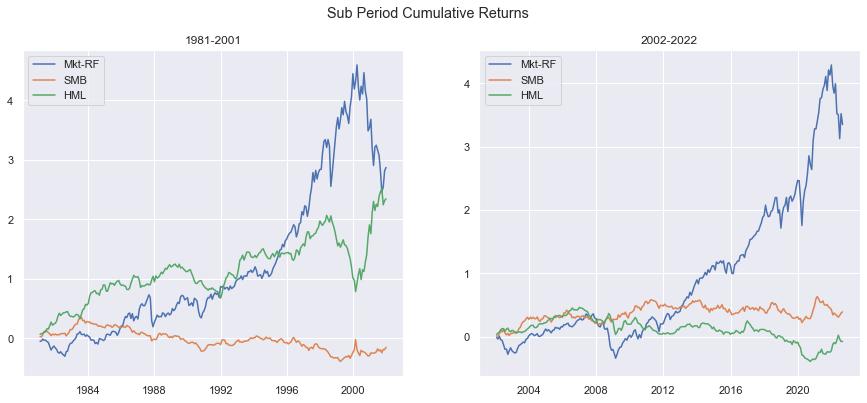

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Sub Period Cumulative Returns')
ax1.plot(((sub_2001 + 1).cumprod() - 1))
ax2.plot(((sub_2022 + 1).cumprod() - 1))

fig.set_figwidth(15)
ax1.legend(sub_2001.columns)
ax2.legend(sub_2022.columns)

ax1.title.set_text('1981-2001')
ax2.title.set_text('2002-2022')

### 2.5) Does it appear that all three factors were valuable in 1981-2001? And post-2001? Would you advise DFA to continue emphasizing all three factors?

As per the graphs above, it appears that the market risk factor was valuable in both sub-samples. However, the Market Factor sees a steep decline with the Tech bubble burst in late 2001, during which time the value factor benefits from the depressed stock prices to post a premium. The Size factor posts near zero or negative returns for the entire sub-sample of 1981-2001. 

With a good recovery post the Tech Bubble burst and similar bull run post the 2008 financial crisis, the Market-factor significantly outperforms Size and Value in the 2002-2022 sub-sample. Both Size and Value factor post meagre returns during this period, with the value factor experiencing declining premiums as companies traded further away from their fundamentals. This Value factor might still be beneficial given its diversification effects.

Though all 3 factors still possess some relevant characterisitics, it appears that Factor rotation might be a better strategy in hindsight. The size factor seems our of favor for a long time now and the returns seem correlated to the Market Factor. DFA should also try to explore other factors such as volatility, liquidity, momentum etc. to generate alpha while sticking to their belief of capital markets being efficient.

## 3. CAPM

#### DFA believes that premia in stocks and stock portfolios is related to the three factors. Let's test 25 equity portfolios that span a wide range of size and value measures

- #### PORTFOLIOS: Monthly total return data on 25 equity portfolios sorted by their size-value characteristics. Denote these as $r^{i}$, for n = 1,....,25.
- #### Note that while the factors were given as excess returns, the portfolios are total returns.
- #### For this entire problem, focus on the 1981-Present subsample.

### 3.1) Summary Statistics.

### For each portfolio,

- ### Use the Risk-Free rate column in the factors tab to convert these total returns to excess returns.
- ### Calculate the (annualized) univariate statistics from 1.1.

In [13]:
port_summary = performance_summary(port_ret.loc['1981-01-01':])
port_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]

,Mean,Volatility,Sharpe Ratio,VaR (0.05)
SMALL LoBM,0.010463,0.272416,0.038410,-0.116482
ME1 BM2,0.095732,0.235906,0.405804,-0.097583
ME1 BM3,0.092913,0.197205,0.471147,-0.086441
ME1 BM4,0.119996,0.191374,0.627023,-0.075179
SMALL HiBM,0.132096,0.207677,0.636062,-0.088348
ME2 BM1,0.060281,0.245699,0.245346,-0.104558
ME2 BM2,0.100629,0.203156,0.495330,-0.084043
ME2 BM3,0.106615,0.183069,0.582375,-0.078669
ME2 BM4,0.107739,0.179220,0.601154,-0.076411
ME2 BM5,0.118123,0.212044,0.557067,-0.094234


### Can the difference in mean excess returns of the portfolios be explained by differences in their volatilities? Or by their VaR(.05) statistics?

Based on the scatter plots below, we do not get a clear indication if the differences in the mean excess returns are explained by differences in either their VaR or their Volatility. Given VaR is a factor of portfolios volatility, more the volatility deeper the VaR threshold, the return differences might be explained slightly by the differences in the volatility. A linear pattern can be observed between volatility and mean excess returns to support the previous arguments, but the evidence is not very concrete from the plots below.

Text(0, 0.5, 'Mean Excess Returns')

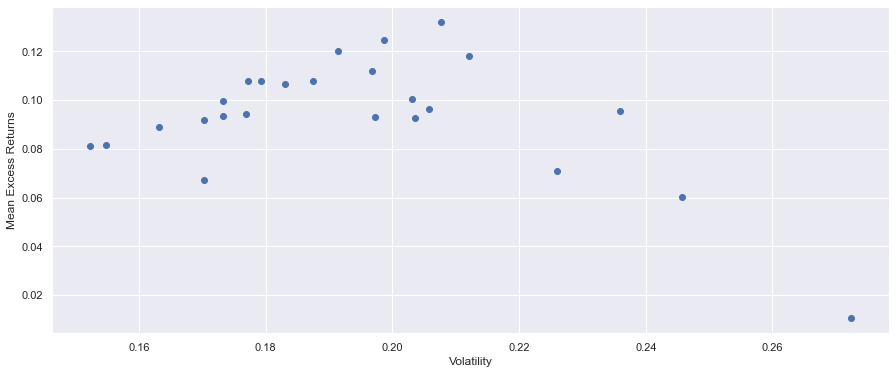

In [14]:
plt.scatter(port_summary.loc[:,['Volatility']],port_summary.loc[:,['Mean']])
plt.xlabel("Volatility")
plt.ylabel("Mean Excess Returns")

Text(0, 0.5, 'Mean Excess Returns')

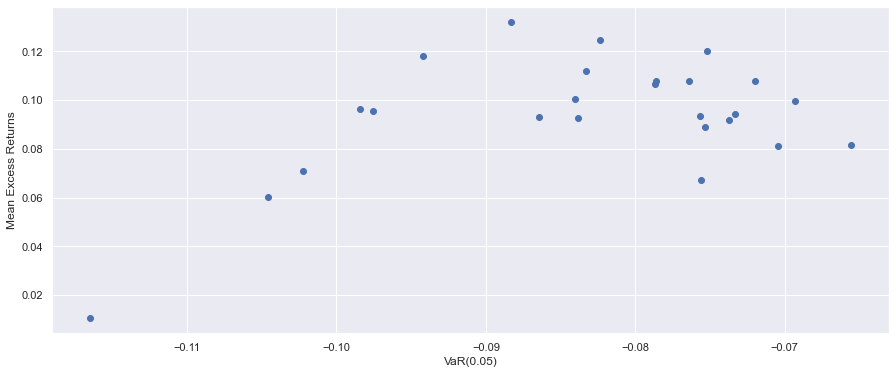

In [15]:
plt.scatter( port_summary.loc[:,['VaR (0.05)']],port_summary.loc[:,['Mean']])
plt.xlabel("VaR(0.05)")
plt.ylabel("Mean Excess Returns")

### 3.2 CAPM

#### The Capital Asset Pricing Model (CAPM) asserts that an asset (or portfolio's) expected excess return is completely a function of its beta to the equity market index (SPY, or in this case, MKT.)
#### Specifically, it asserts that, for any excess return, $\tilde{r}^{i}$, its mean is proportional to the mean excess return of the market, $\tilde{r}^{m}$, where the proporitonality is the regression beta of $\tilde{r}^{i}$ on $\tilde{r}^{m}$.

#### <center>$\mathop{\mathbb{E}}[\tilde{r}^{i}_{t}] = \beta \mathop{\mathbb{E}}[\tilde{r}^{m}_{t}]$</center>
#### Let's examine whether that seems plausible.

### 3.2.a) For each of the n = 25 test portfolios, run the CAPM time-series regression: <br> 
###   <center> $\tilde{r}_{t}^{i}$ = $α^{i} + β^{i,m}\tilde{r}^{m}_{t} + ε_{t}$ </center>
### So you are running 25 separate regressions, each using the T-sized sample of time-series data.

In [16]:
portfolios = port_ret.columns
factor = factors['1981-01-01':]['Mkt-RF']

df_lst= []
for port in portfolios:
    fund_ret = port_ret['1981-01-01':][port]
    reg = regression_based_performance(factor,fund_ret,0)
    beta = reg[0][0]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst.append(pd.DataFrame([[beta,alpha,r_squared,treynor_ratio,information_ratio]],columns=['Market Beta','Alpha','R-Squared','Treynor Ratio','Information Ratio'],index = [port]))


### 3.2.b) Report the estimated $β^{i,m}$, Treynor Ratio, $α^{i}$, and Information Ratio for each of the n regressions.

In [17]:
reg_performance = pd.concat(df_lst)
reg_performance

,Market Beta,Alpha,R-Squared,Treynor Ratio,Information Ratio
SMALL LoBM,1.360046,-0.098676,0.603114,0.007693,-0.574986
ME1 BM2,1.170212,0.001824,0.595400,0.081807,0.012154
ME1 BM3,1.036480,0.009732,0.668413,0.089642,0.085739
ME1 BM4,0.965225,0.042540,0.615535,0.124319,0.358477
SMALL HiBM,0.990693,0.052596,0.550631,0.133336,0.377783
ME2 BM1,1.343338,-0.047520,0.723306,0.044874,-0.367683
ME2 BM2,1.128609,0.010056,0.746773,0.089162,0.098400
ME2 BM3,1.019328,0.024816,0.750164,0.104593,0.271190
ME2 BM4,0.965384,0.030264,0.702078,0.111602,0.309418
ME2 BM5,1.108553,0.029160,0.661333,0.106556,0.236327


### 3.2.c) If CAPM were true, what would be true of the Treynor Ratios, alphas, and Information Ratios?

If CAPM were true, we would observe **same** Treynor ratios for all 25 portfolios as the portfolio returns should completely be a function of market returns (SPY). However, as we observe, most portfolios have varying Treynor ratios, indicating towards and high alpha and/or low regression beta. 

The alphas should similarly have been lower (ideally 0) for all portfolios and we should have also seen low absolute magnitude of the residuals, resulting in lower (ideally 0) information ratios. But we observe, that the alphas are still higher than expected and the Information ratios are higher than expected indicating towards presence of other regressors that should be included in the model.

## 3.3) Cross-sectional Estimation

#### Let's test (CAPM) directly. We already have what we need:

- #### The dependent variable, (y): mean excess returns from each of the n = 25 portfolios.
- #### The regressor, (x): the market beta from each of the n = 25 time-series regressions.

- #### Then we can estimate the following equation:

<center> $  \underbrace{\mathop{\mathbb{E}}[\tilde{r}^{i}]}_\text{n x 1 data} = 
    \underbrace{\eta}_\text{regression intercept} +
    \underbrace{\beta^{i,m}}_\text{n x 1 data} *\underbrace{\lambda_{m}}_\text{regression estimate} + \underbrace{\upsilon}_\text{n x 1 residuals}
 $ </center>
 
- #### Note that we use sample means as estimates of $\mathop{\mathbb{E}}[\tilde{r}^{i}]$.
- #### This is a weird regression! The regressors are the betas from the time-series regressions we already ran!
- #### This is a single regression, where we are combining evidence across all n = 25 series. Thus, it is a cross-sectional regression!
- #### The notation is trying to emphasize that the intercept is different than the time-series $\alpha$ and that the regressor coefficient is different than the time-series betas.

### 3.2.a) Report the R-squared of this regression.
### 3.2.b) Report the intercept, $\upsilon$.
### 3.2.c) Report the regression coefficient, $\lambda_{m}$.

In [29]:
fund_ret = port_ret.loc['1981-01-01':].mean()
factor = reg_performance['Market Beta']
reg = regression_based_performance(factor,fund_ret,0)
beta = reg[0][0]
treynor_ratio = reg[1]
information_ratio = reg[2]
alpha = reg[3]
r_squared = reg[4]
cross_sec_reg = pd.DataFrame([[beta,alpha/12,r_squared]],columns=['Beta','Alpha','R-Squared'],index = ['Cross-Sectional Estimation'])
cross_sec_reg


,Beta,Alpha,R-Squared
Cross-Sectional Estimation,-0.00818,0.016498,0.258245


###  What would these three statistics be if (CAPM) were true?

If CAPM were true and the regression beta for the excess returns on the market factor explained the portfolio excess returns, we would expect a very low alpha, a high beta and a very high R-Squared from the above regression. Since, all market betas should be explaining the same factor i.e. SPY, we should expect them to be heavily correlated.


### 3.4) Broadly speaking, do these results support DFA's belief in size and value portfolios containing premia unrelated to the CAPM?

Low R-Squared and Betas and higher alpha from the cross-sectional regression in the previous question, indicat the presence of other risk factors in the market that can explain excess returns of equity portfolios. Also, as shown by the Fama-French paper, size and value have posted premiums in the past and thus can be used to explain mean excess returns in better capacity than CAPM alone. These results do support DFA's belief in size and value portfolios containing premia unrelated to CAPM.

Using Size and Value as additional factors in the regression for the 25 portfolios, we see a higher R-Squared in the regression, further strengthening DFA's belief in existence of premia in Value and Size Factors

# 4) Extensions

### 4.1) Re-do the analysis of 3.3 and 3.4, but instead of using the market return as the factor, use all three factors, (MKT, SMB, and HML). Note again that all three are already given as excess returns, so there is no need to use the risk-free rate data.
### Thus, instead of testing (CAPM), you will be testing the Fama-French 3-Factor Model.

#### <center>$\mathop{\mathbb{E}}[\tilde{r}^{i}_{t}] = \beta^{i,m} \mathop{\mathbb{E}}[\tilde{r}^{m}_{t}] +  \beta^{i,s} \mathop{\mathbb{E}}[\tilde{r}^{s}_{t}] +  \beta^{i,v} \mathop{\mathbb{E}}[\tilde{r}^{v}_{t}]$</center>

In [19]:
portfolios = port_ret.columns
factor = factors.loc['1981':]

df_lst_ff= []
for port in portfolios:
    fund_ret = port_ret['1981-01-01':][port]
    reg = regression_based_performance(factor,fund_ret,0)
    beta_mkt = reg[0][0]
    beta_sml = reg[0][1]
    beta_hml = reg[0][2]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst_ff.append(pd.DataFrame([[beta_mkt,beta_sml,beta_hml,alpha,r_squared,treynor_ratio,information_ratio]],columns=['Market Beta','Size Beta','Value Beta','Alpha','R-Squared','Treynor Ratio','Information Ratio'],index = [port]))

reg_performance_ff = pd.concat(df_lst_ff)
reg_performance_ff


,Market Beta,Size Beta,Value Beta,Alpha,R-Squared,Treynor Ratio,Information Ratio
SMALL LoBM,1.116175,1.372219,-0.262905,-0.083196,0.891880,0.009374,-0.928832
ME1 BM2,0.972187,1.314518,-0.012622,0.005916,0.912405,0.098471,0.084678
ME1 BM3,0.921626,1.046313,0.277420,0.000084,0.945551,0.100814,0.001869
ME1 BM4,0.878290,1.057983,0.476788,0.023964,0.938066,0.136624,0.503265
SMALL HiBM,0.935865,1.060999,0.695626,0.024204,0.869853,0.141148,0.323126
ME2 BM1,1.142436,1.015023,-0.332342,-0.029880,0.940685,0.052765,-0.499362
ME2 BM2,1.012003,0.901247,0.120149,0.007080,0.939822,0.099435,0.142076
ME2 BM3,0.972962,0.707765,0.398220,0.008832,0.919854,0.109578,0.170470
ME2 BM4,0.940884,0.742195,0.579725,0.006228,0.937383,0.114508,0.138965
ME2 BM5,1.093340,0.921874,0.822365,-0.005280,0.951121,0.108038,-0.112717


In [20]:
fund_ret = port_summary['Mean']
factor = reg_performance_ff.loc[:,['Market Beta','Size Beta','Value Beta']]
reg = regression_based_performance(factor,fund_ret,0)
beta_mkt = reg[0][0]
beta_size = reg[0][1]
beta_value = reg[0][2]
treynor_ratio = reg[1]
information_ratio = reg[2]
alpha = reg[3]
r_squared = reg[4]
cross_sec_reg_ff = pd.DataFrame([[beta_mkt,beta_size,beta_value,alpha/12,r_squared]],columns=['Mkt Beta','Size Beta','Value Beta','Alpha','R-Squared'],index = ['Cross-Sectional Estimation'])
cross_sec_reg_ff


,Mkt Beta,Size Beta,Value Beta,Alpha,R-Squared
Cross-Sectional Estimation,-0.095676,0.002894,0.03621,0.17974,0.466514


### 4.2) Re-do the analysis of 3.3 and 3.3, but instead of using the market return as the factor, use a new factor: the in-sample tangency portfolio of the n = 25 portfolios.

#### You will not use the factor data for this problem!
- #### Calculate $\tilde{r}^{tan}$ by solving the MV optimization of the n excess returns.
- #### Consider this to be your single factor.

#### Instead of testing (CAPM), you will test the MV model:

#### <center>$\mathop{\mathbb{E}}[\tilde{r}^{i}_{t}] = \beta^{i,tan} \mathop{\mathbb{E}}[\tilde{r}^{tan}_{t}]$</center> 

#### What do you find?

In [21]:
mean_excess_ret =  np.array(port_ret['1981':].mean())

tangency_port = tangency_portfolio_rfr(mean_excess_ret,port_ret['1981':].cov())

TangencyPort_df = pd.DataFrame(tangency_port,columns= ["Tangency Portfolio Weight"],index=port_summary.index)
TangencyRets = (port_ret @ TangencyPort_df).rename(columns={'Tangency Portfolio Weight':'Tangency Returns'})
TangencyRets

portfolios = port_ret.columns
factor = TangencyRets.loc['1981':]

df_lst_tang= []
for port in portfolios:
    fund_ret = port_ret['1981-01-01':][port]
    reg = regression_based_performance(factor,fund_ret,0)
    beta_tang = reg[0][0]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst_tang.append(pd.DataFrame([[beta_tang,treynor_ratio,information_ratio,alpha,r_squared]],columns=['Tangency Beta','Treynor Ratio','Information Ratio','Alpha','R-Squared'],index = [port]))

reg_performance_tang = pd.concat(df_lst_tang)
reg_performance_tang

,Tangency Beta,Treynor Ratio,Information Ratio,Alpha,R-Squared
SMALL LoBM,0.025858,0.404647,3.458487e-15,0.0,0.000411
ME1 BM2,0.236581,0.404647,5.555822e-15,0.0,0.045892
ME1 BM3,0.229614,0.404647,5.490031e-15,0.0,0.061861
ME1 BM4,0.296544,0.404647,1.858781e-15,0.0,0.109565
SMALL HiBM,0.326447,0.404647,2.899786e-15,0.0,0.112747
ME2 BM1,0.148972,0.404647,5.489776e-15,0.0,0.016775
ME2 BM2,0.248684,0.404647,1.579134e-15,0.0,0.068375
ME2 BM3,0.263477,0.404647,1.755108e-15,0.0,0.094517
ME2 BM4,0.266254,0.404647,3.393155e-15,0.0,0.100711
ME2 BM5,0.291915,0.404647,1.171574e-15,0.0,0.086481


In [22]:
fund_ret = port_summary['Mean']
factor = reg_performance_tang.loc[:,['Tangency Beta']]
reg = regression_based_performance(factor,fund_ret,0)
beta_tang = reg[0][0]
treynor_ratio = reg[1]
alpha = reg[3]
r_squared = reg[4]
cross_sec_reg_tang = pd.DataFrame([[beta_tang,alpha,r_squared]],columns=['Tangency Beta','Alpha','R-Squared'],index = ['Cross-Sectional Estimation'])
cross_sec_reg_tang

,Tangency Beta,Alpha,R-Squared
Cross-Sectional Estimation,0.404647,0.0,1.0


### 4.3) In problem 2.3, we measured how well the CAPM performs by running the analogous regression. In fact, we could have assessed it directly from the time-series regressions.

In [23]:
portfolios = port_ret.columns
factor = factors['1981-01-01':]['Mkt-RF']

resid = pd.DataFrame()
for port in portfolios:
    fund_ret = port_ret['1981-01-01':][port]
    reg = regression_based_performance(factor,fund_ret,0)
    resid[port] = reg[6]

### 4.3.a) Report the mean-absolute-error of the CAPM:

### <center>$\text{MAE} = \frac{1}{n}\sum^{n}_{i=1}|\alpha_{i}|$ </center>

In [24]:
pd.DataFrame([(((reg_performance['Alpha']).abs().mean()))], columns = ['MAE (%)'], index = ['CAPM'])

,MAE (%)
CAPM,0.024271


### 4.3.b) Under classic statistical assumptions, we can test the null hypothesis that the CAPM works by calculating,

### <center> $\text{H} = \text{T} \ [1+(\text{SR}_{m})^{2}]^{-1} \alpha^{'}\Sigma^{-1}_{\epsilon}\alpha ~ \chi^{2}_{n}$ </center>

- ### Note the following:
- ### $\alpha$ is an n x 1 vector of the individual regression alphas, $\alpha^{i}$.
- ### $\Sigma_{\epsilon}$ is the n x n covariance matrix of the time-series of regression residuals, $\epsilon^{i}$, corresponding to each regression.
- ### $\text{SR}_{m}$ is the Sharpe-Ratio of $\tilde{r}^{m}$.

### The test statistic, H, has a chi-squared distribution with n = 25 degrees of freedom. So under the null hypothesis of the CAPM holding, H should be small, and the distribution allows us to calculate the probability of seeing such a large H, conditional on the CAPM being true.

In [25]:
T = port_ret['1981':].shape[0]
SR = factors['1981':]['Mkt-RF'].mean() *12/ factors['1981':]['Mkt-RF'].std()*np.sqrt(12)
Sigma = resid.cov()
Sigma_inv = pd.DataFrame(np.linalg.inv(Sigma), index=Sigma.index, columns=Sigma.columns)
alpha = reg_performance['Alpha']

H = T * (1 + SR**2)**(-1) * (alpha @ Sigma_inv @ alpha)

print('H = {:.2f}'.format(H))
pvalue = 1 - stats.chi2.cdf(H, df=25)
print('p-value = {:.4f}'.format(pvalue))

H = 521.63
p-value = 0.0000


### 4.3.c) Which is a stricter test: checking whether any of the n values of $\alpha^{i}$ have a statistically significant t-test or checking whether H calculated above is significant?

- By definition, a joint test is stricter than testing the conditions individually.

- In our case, we can see that most of the alphas (20 alphas) are not significant (as -value  0.05) while 5 alphas are signficant (as -value  0.05) as judged by their individual -stats, yet all of them are jointly significant as judged by this joint test.

### 4.3.d) Conceptually, how does the test-statistic H relate to checking whether $\tilde{r}^{m}$ spans the tangency portfolio?

- We have demonstrated that an LFM is exactly the same as asserting that a set of factors spans the MV frontier, (and thus spans the tangency portfolio.) 
- Thus, this test can be interpreted as checking whether investing in the alphas gets beyond the tangency portfolio. The test stat is basically comparing the square SR of the alphas to the square SR of the factors.